# Neural Style Transfer
---
Group 7: Samarth Kumar, Cliffton Lang, Jannatul Fhirdose Mohammad

Import Dependencies

In [1]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub

## Developing the neural network using TensorFlow

In [2]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

### Method and Model Definitions

In [3]:
# Format an image from the tensor.
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]

    return PIL.Image.fromarray(tensor)

# Load the image and adjust the sizing.
def load_img(path_to_img):
    max_dim = 512

    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Display the image.
def imshow(image, title=None):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    plt.imshow(image)

    if title:
      plt.title(title)

# Import the VGG-19 model, a pretrained model trained from ImageNet data.
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)

    return model

# Calculate the gram matrix to compare different feature matrices of the CNN.
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)

    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    gram = result/(num_locations)

    return gram

# Defining a class for our style and content.
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
      super(StyleContentModel, self).__init__()

      self.vgg = vgg_layers(style_layers + content_layers)
      self.style_layers = style_layers
      self.content_layers = content_layers
      self.num_style_layers = len(style_layers)
      self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict,
                'style': style_dict}


In [4]:
# Clip values for stability.
def clip_0_1(image):
    return tf.clip_by_value(image,
                            clip_value_min=0.0, clip_value_max=1.0)

# Calculate the losses.
def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-2, content_weight=1e4):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_outputs)

    # Content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_outputs)

    return style_loss + content_loss, style_loss, content_loss

### Overall training loop

In [5]:
def initialize_and_train(content_path, style_path, save_path, epochs=5, steps_per_epoch=100):
    # Load content and style images.
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    # Display images.
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
    plt.show()

    # Extract style and content layers.
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']

    # Initialize the model and optimizer.
    extractor = StyleContentModel(style_layers, content_layers)
    opt = tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.90, epsilon=1e-1)

    # Set up style and content targets.
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    # Prepare image variable for training.
    image = tf.Variable(content_image)

    total_steps = 0

    @tf.function
    def train_step(image, extractor, style_targets, content_targets, opt, total_variation_weight=30):
        with tf.GradientTape() as tape:
            outputs = extractor(image)

            loss, style_loss_val, content_loss_val = style_content_loss(outputs, style_targets, content_targets)

            loss += total_variation_weight * tf.image.total_variation(image)

        grad = tape.gradient(loss, image)

        opt.apply_gradients([(grad, image)])

        image.assign(clip_0_1(image))

        return style_loss_val, content_loss_val

    # Main training loop
    all_style_losses = []
    all_content_losses = []
    start = time.time()

    for n in range(epochs):
        print(f"Epoch {n+1}/{epochs}")

        for m in range(steps_per_epoch):
            # Calculate loss.
            style_loss, content_loss = train_step(image, extractor, style_targets, content_targets, opt)

            # Store the losses.
            all_style_losses.append((total_steps, style_loss.numpy().item()))
            all_content_losses.append((total_steps, content_loss.numpy().item()))

            total_steps += 1
            print(".", end='', flush=True)

        print("\n")

    end = time.time()
    print("\nTotal time: {:.1f} seconds".format(end - start))

    # Save the final generated image.
    if save_path:
        # Get base filenames for content and style images.
        content_name = os.path.splitext(os.path.basename(content_path))[0]
        style_name = os.path.splitext(os.path.basename(style_path))[0]

        # Construct the final file path.
        final_image_path = os.path.join(save_path, f"{content_name}_{style_name}.jpg")

        # Save the final transformed image.
        final_image = tensor_to_image(image)
        final_image.save(final_image_path)
        print(f"Final image saved at {final_image_path}")

    return all_style_losses, all_content_losses, final_image_path

# Train the model using our content and style image

Get file path

In [6]:
base_path = os.getcwd()

In [7]:
# Paths to a single style and content image.
base_path = os.getcwd()
content_image_path = os.path.join(base_path, 'hallstatt.jpg')
style_image_path = os.path.join(base_path, 'starry_night.jpg')
save_path = os.path.join(base_path)

Applying style to content image: /content/hallstatt.jpg
 - Using style image: /content/starry_night.jpg


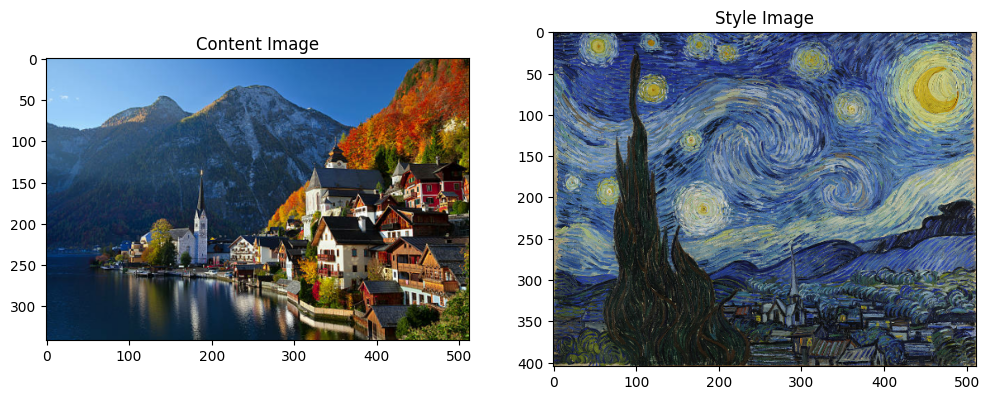

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


Epoch 1/5
....................................................................................................

Epoch 2/5
....................................................................................................

Epoch 3/5
....................................................................................................

Epoch 4/5
....................................................................................................

Epoch 5/5
....................................................................................................


Total time: 40.2 seconds
Final image saved at /content/hallstatt_starry_night.jpg


In [8]:
# Apply style transfer to the single content and style image.
print(f"Applying style to content image: {content_image_path}")
print(f" - Using style image: {style_image_path}")
style_loss_array, content_loss_array, final_image_path = initialize_and_train(content_image_path, style_image_path, save_path)

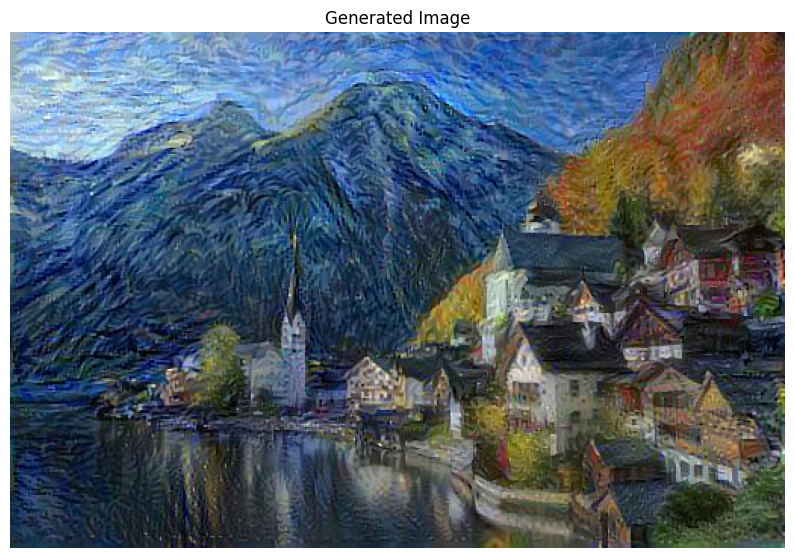

In [9]:
# Display the final generated image
final_image = PIL.Image.open(os.path.join(save_path, final_image_path))
plt.figure(figsize=(10, 8))
plt.imshow(final_image)
plt.title('Generated Image')
plt.axis('off')
plt.show()